In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date

In [32]:
demand_df = pd.read_excel(r'../data/Region_CAL.xlsx')
demand_df = demand_df.iloc[30721:45937]
demand_df = demand_df[["Local Time", "D"]]
demand_df.rename(columns = {"Local Time": "time", "D":"demand"}, inplace=True)
demand_df["hour"] = demand_df.time.apply(lambda x:x.hour)
demand_df["month"] = demand_df.time.apply(lambda x:x.month)
demand_df["dayofmonth"] = demand_df.time.apply(lambda x:x.day)
demand_df["dayofweek"] = demand_df.time.apply(lambda x:x.dayofweek)
demand_df["date"] = demand_df.time.apply(lambda x:x.date().strftime('%Y-%m-%d'))

demand_df["key"] =list(zip(demand_df.date, demand_df.hour))
demand_df.head()

,time,demand,hour,month,dayofmonth,dayofweek,date,key
30721,2019-01-01 01:00:00,26876.0,1,1,1,1,2019-01-01,"(2019-01-01, 1)"
30722,2019-01-01 02:00:00,25989.0,2,1,1,1,2019-01-01,"(2019-01-01, 2)"
30723,2019-01-01 03:00:00,25295.0,3,1,1,1,2019-01-01,"(2019-01-01, 3)"
30724,2019-01-01 04:00:00,24884.0,4,1,1,1,2019-01-01,"(2019-01-01, 4)"
30725,2019-01-01 05:00:00,24922.0,5,1,1,1,2019-01-01,"(2019-01-01, 5)"


In [33]:
weather_df = pd.read_csv(r'../data/LA_weather.csv')
weather_df = weather_df[["DATE","HourlyDryBulbTemperature","HourlyPrecipitation","HourlyRelativeHumidity"]]
weather_df["datetime"] = weather_df.DATE.apply(lambda x:datetime.strptime(x,"%Y-%m-%dT%H:%M:%S"))
weather_df["hour"] = weather_df.datetime.apply(lambda x:x.hour)
weather_df["date"] = weather_df.datetime.apply(lambda x:x.date().strftime('%Y-%m-%d'))
weather_df["key"] =list(zip(weather_df.date, weather_df.hour))
weather_df = weather_df[weather_df['HourlyDryBulbTemperature'].notna()]

weather_df.head()

c:\users\psingh\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3,19,25,26,27,28,29,30,31,51,63,69,71,95,119) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DATE,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,datetime,hour,date,key
0,2019-01-01T00:49:00,52.0,NaN,19.0,2019-01-01 00:49:00,0,2019-01-01,"(2019-01-01, 0)"
1,2019-01-01T00:53:00,51.0,0.00,19.0,2019-01-01 00:53:00,0,2019-01-01,"(2019-01-01, 0)"
2,2019-01-01T01:53:00,52.0,0.00,18.0,2019-01-01 01:53:00,1,2019-01-01,"(2019-01-01, 1)"
3,2019-01-01T02:53:00,49.0,0.00,21.0,2019-01-01 02:53:00,2,2019-01-01,"(2019-01-01, 2)"
4,2019-01-01T03:53:00,43.0,0.00,37.0,2019-01-01 03:53:00,3,2019-01-01,"(2019-01-01, 3)"


In [34]:
temperature_lookup_dict = dict(zip(weather_df["key"].tolist(), weather_df['HourlyDryBulbTemperature'].tolist()))
humidity_lookup_dict = dict(zip(weather_df["key"].tolist(), weather_df['HourlyRelativeHumidity'].tolist()))
rain_lookup_dict = dict(zip(weather_df["key"].tolist(), weather_df['HourlyPrecipitation'].tolist()))
demand_df['temperature'] = demand_df['key'].map(temperature_lookup_dict)
demand_df['humidity'] = demand_df['key'].map(humidity_lookup_dict)
demand_df['rain'] = demand_df['key'].map(rain_lookup_dict)

demand_df = demand_df[['hour', 'dayofweek', 'dayofmonth', 'month', 'temperature', 'demand']]
demand_df[demand_df.isnull().any(axis=1)]
demand_df = demand_df[demand_df.notna()]


demand_df = demand_df[demand_df['temperature'].notna()]
demand_df = demand_df[demand_df['demand'].notna()]


In [35]:
##separating the df into training & testing
demand_df_train = demand_df.iloc[:8682, :]
demand_df_test = demand_df.iloc[8682:, :]

demand_df_pre = demand_df_test.iloc[:1535,:]
demand_df_post = demand_df_test.iloc[1535:,:]



In [36]:
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

1517311.458582002
0.9624305218942638


<ipython-input-37-b0fb11ffaa09>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["predict"] = clf.predict(X_test)
<ipython-input-37-b0fb11ffaa09>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["true"] = y_test


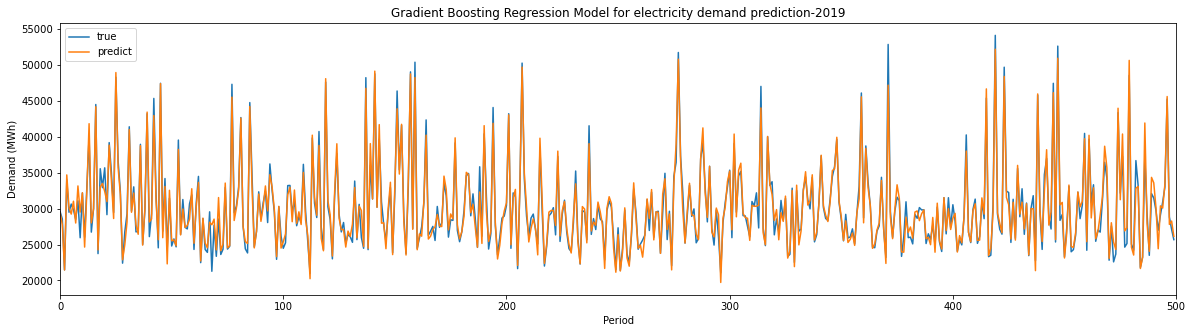

In [37]:
###Gradient Boosting regression
from sklearn.utils import shuffle
X, y = shuffle(demand_df_train[['hour', 'dayofweek', 'dayofmonth', 'month', 'temperature']], demand_df_train['demand'], random_state = 13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print(mse)
print(clf.score(X_test,y_test))

pred_df = X_test
pred_df["predict"] = clf.predict(X_test)  
pred_df["true"] = y_test
pred_df = pred_df.reset_index()

plt.figure(figsize=(20,5))
plt.plot(pred_df[:500].true)
plt.plot(pred_df[:500].predict)


plt.legend(["true", "predict"])
plt.xlabel("Period")
plt.xlim(0,500)
plt.ylabel("Demand (MWh)")
plt.title("Gradient Boosting Regression Model for electricity demand prediction-2019")
plt.savefig("pred_2019.png")




9460128.232046602
0.7914586355181423


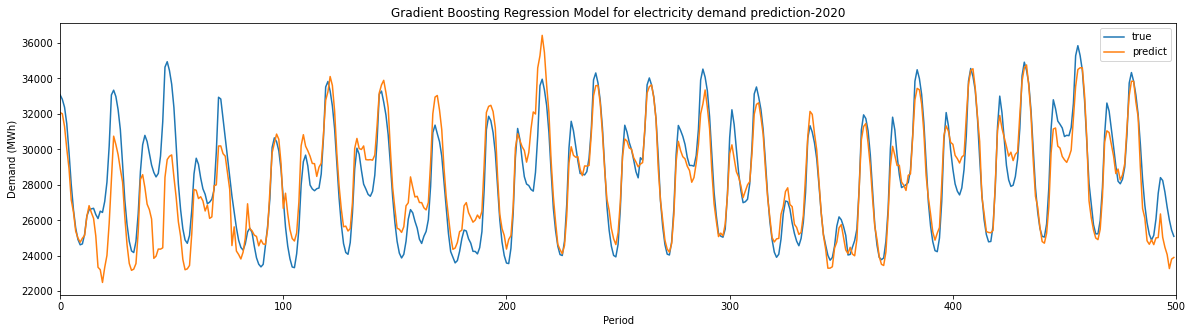

In [38]:
## making prediction on df_2020
###Gradient Boosting regression
from sklearn.utils import shuffle
X, y = demand_df_test[['hour', 'dayofweek', 'dayofmonth', 'month', 'temperature']], demand_df_test['demand']
X = X.astype(np.float32)
X_test, y_test = X, y

from sklearn import ensemble
mse = mean_squared_error(y_test, clf.predict(X_test))

print(mse)
print(clf.score(X_test,y_test))

pred_df = X_test
pred_df["predict"] = clf.predict(X_test)  
pred_df["true"] = y_test
pred_df = pred_df.reset_index()

plt.figure(figsize=(20,5))
plt.plot(pred_df[:500].true)
plt.plot(pred_df[:500].predict)


plt.legend(["true", "predict"])
plt.xlabel("Period")
plt.xlim(0,500)
plt.ylabel("Demand (MWh)")
plt.title("Gradient Boosting Regression Model for electricity demand prediction-2020")
plt.savefig("pred_2020.png")


In [39]:
avg_hourly_demand_2020_true = []
for j in range(1,10):
    flag = 0
    march_demand_2020 = []
    for i in range(6446):
        if pred_df.iloc[i][4] == j:
            flag = 1
        else:
            flag = 0
        if flag == 1:
            march_demand_2020.append((pred_df.iloc[i][7], pred_df.iloc[i][1])) # 6: predict, 7: true

    march_2020_avg_hourly = [[] for i in range(24)]
    for d, h in march_demand_2020:
        march_2020_avg_hourly[int(h)].append(d)

    march_2020_avg_hourly = [sum(h)/len(h) for h in march_2020_avg_hourly]
    avg_hourly_demand_2020_true.append(march_2020_avg_hourly)

In [40]:
avg_hourly_demand_2020_pred = []
for j in range(1,10):
    flag = 0
    march_demand_2020 = []
    for i in range(6446):
        if pred_df.iloc[i][4] == j:
            flag = 1
        else:
            flag = 0
        if flag == 1:
            march_demand_2020.append((pred_df.iloc[i][6], pred_df.iloc[i][1])) # 6: predict, 7: true

    march_2020_avg_hourly = [[] for i in range(24)]
    for d, h in march_demand_2020:
        march_2020_avg_hourly[int(h)].append(d)

    march_2020_avg_hourly = [sum(h)/len(h) for h in march_2020_avg_hourly]
    avg_hourly_demand_2020_pred.append(march_2020_avg_hourly)

In [41]:
avg_hourly_demand_2019 = []

for j in range(1,13): 
    flag = 0
    march_demand_2019 = []
    for i in range(8682):
        if demand_df_train.iloc[i][3] == j:
            flag = 1
        else:
            flag = 0
        if flag == 1:
            march_demand_2019.append((demand_df_train.iloc[i][5], demand_df_train.iloc[i][0]))

    march_2019_avg_hourly = [[] for i in range(24)]
    for d, h in march_demand_2019:
        march_2019_avg_hourly[int(h)].append(d)

    march_2019_avg_hourly = [sum(h)/len(h) for h in march_2019_avg_hourly]
    avg_hourly_demand_2019.append(march_2019_avg_hourly)



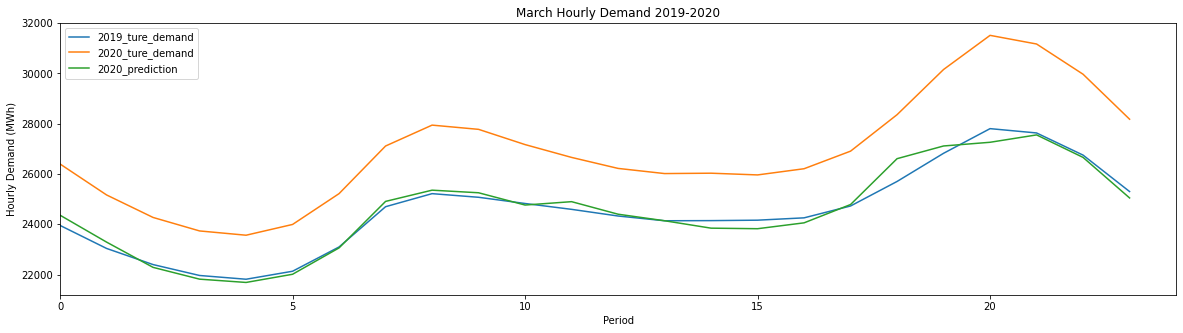

In [42]:
# avg_hourly_demand_2019, avg_hourly_demand_2020_pred, avg_hourly_demand_2020_true

##plotting analysis graphs
month =3

plt.figure(figsize=(20,5))
plt.plot(avg_hourly_demand_2019[month-1])
plt.plot(avg_hourly_demand_2020_true[month-1])
plt.plot(avg_hourly_demand_2020_pred[month-1])


plt.legend(["2019_ture_demand", "2020_ture_demand","2020_prediction"])
plt.xlabel("Period")
plt.xlim(0,24)
plt.ylabel("Hourly Demand (MWh)")
plt.title("March Hourly Demand 2019-2020")
plt.savefig("march_hourly.png")

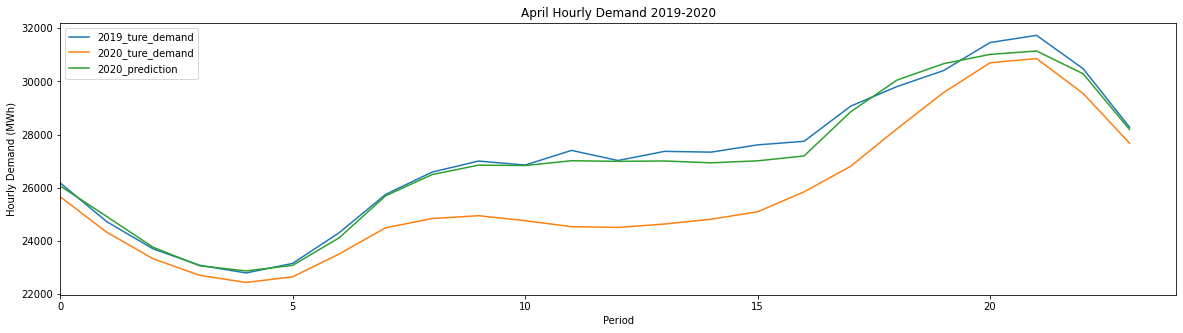

In [43]:
# avg_hourly_demand_2019, avg_hourly_demand_2020_pred, avg_hourly_demand_2020_true

##plotting analysis graphs
month =4

plt.figure(figsize=(20,5))
plt.plot(avg_hourly_demand_2019[month-1])
plt.plot(avg_hourly_demand_2020_true[month-1])
plt.plot(avg_hourly_demand_2020_pred[month-1])


plt.legend(["2019_ture_demand", "2020_ture_demand","2020_prediction"])
plt.xlabel("Period")
plt.xlim(0,24)
plt.ylabel("Hourly Demand (MWh)")
plt.title("April Hourly Demand 2019-2020")
plt.savefig("april_hourly.png")

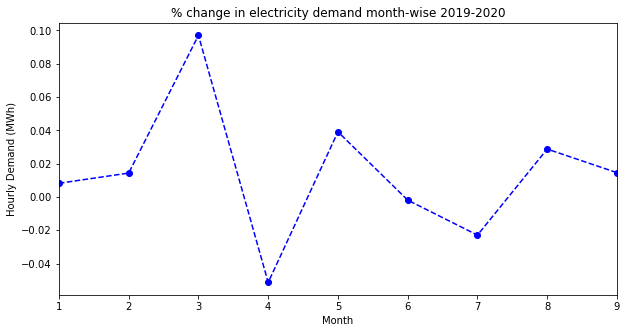

In [44]:
change_in_percentage = []
for i in range(9):
    value = (sum(avg_hourly_demand_2020_true[i])-sum(avg_hourly_demand_2019[i]))/sum(avg_hourly_demand_2019[i])
    change_in_percentage.append(value)
    
plt.figure(figsize=(10,5))    
plt.plot([i for i in range(1, 10)], change_in_percentage,color='b', linestyle='dashed', marker='o')
plt.xlabel("Month")
plt.xlim(1,9)
plt.ylabel("Hourly Demand (MWh)")
plt.title("% change in electricity demand month-wise 2019-2020")
plt.savefig("change_%_electricity.png")

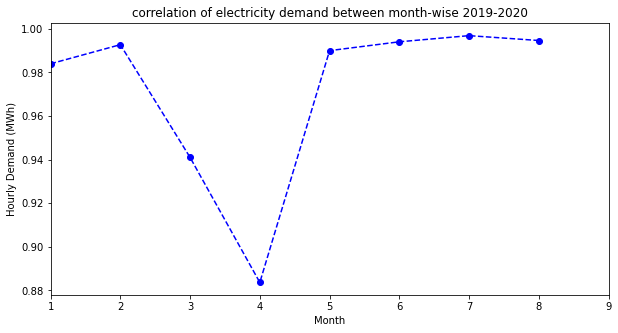

In [45]:
cor_avg_hr_month = []
for i in range(9):
    x = np.array(avg_hourly_demand_2020_true[i])
    y = np.array(avg_hourly_demand_2019[i])
    cor_avg_hr_month.append(np.corrcoef(x, y)[1][0])
plt.figure(figsize=(10,5))    
plt.plot(cor_avg_hr_month, color='b', linestyle='dashed', marker='o')

plt.xlabel("Month")
plt.xlim(1,9)
plt.ylabel("Hourly Demand (MWh)")
plt.title("correlation of electricity demand between month-wise 2019-2020")
plt.savefig("cor_months.png")